# Imports

In [1]:
try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")
    
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [25]:
from torch.utils.tensorboard import SummaryWriter
import tensorboard
%load_ext tensorboard
# Writer will output to ./runs/ directory by default
train_writer = SummaryWriter('./logs/train')
valid_writer = SummaryWriter('./logs/valid')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
from torch import nn
import torch
import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

import pickle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
ds_train = torchvision.datasets.MNIST(
    '../Aula14/mnist_train/', transform=torchvision.transforms.ToTensor())
ds_valid = torchvision.datasets.MNIST('../Aula14/mnist_train/', False,
                                      transform=torchvision.transforms.ToTensor())

In [29]:
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=8)
dl_valid = DataLoader(ds_valid, batch_size=128, num_workers=8)

In [30]:
x, y = next(iter(dl_train))

In [31]:
grid = make_grid(x, nrow=16)

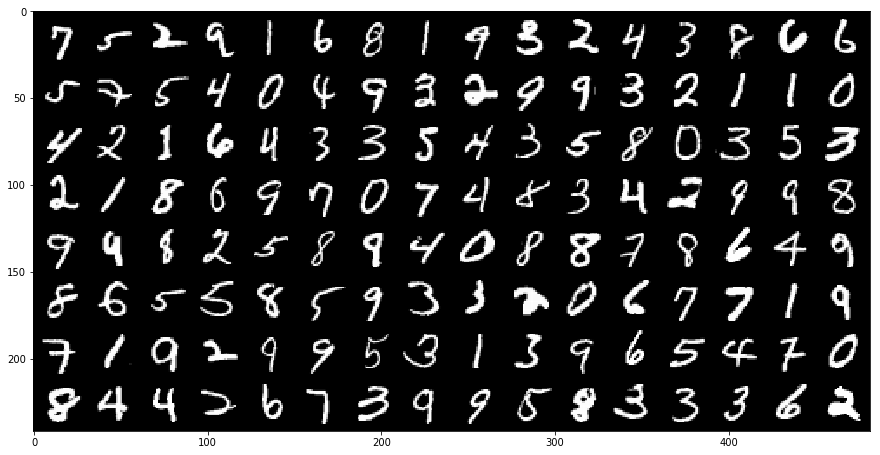

In [32]:
plt.figure(figsize=(15, 15))
plt.imshow(grid.numpy().transpose(1, 2, 0))

# Autoencoder

In [33]:
class Autoencoder(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            self.linear_block(input_size, 512),
            self.linear_block(512, 128),
            nn.Linear(128, 3)
        )
        self.decoder = nn.Sequential(
            self.linear_block(3, 128),
            self.linear_block(128, 512),
            nn.Linear(512, input_size)
        )
    
    @staticmethod
    def linear_block(in_size, out_size):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU()
        )
    def __call__(self, x, decode=True):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        if decode:
            return self.decoder(x)
        return x

In [34]:
model = Autoencoder(1 * 28 * 28)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
    )
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

In [36]:
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [38]:
# escrevendo no tensorboard
train_writer.add_graph(model, x.to(device))

In [39]:
def loss_on_dataloader(model, dataloader):
    losses = []
    model.eval()
    for x, _ in dataloader:
        out = model(x.to(device))
        # append loss
        losses += [
            loss_fn(out.to('cpu').float(), x.float().view(x.shape[0],-1)).detach().numpy()
        ]
    return np.array(losses).mean()

In [40]:
best_loss = loss_on_dataloader(model, dl_valid)
best_loss

0.11765545

In [41]:
red = '\33[91m'
green = '\33[92m'
blue = '\33[94m'
end_color = '\033[0m'

In [42]:
%%time
train_losses, valid_losses = [], []
epochs = 10
for ep in range(epochs):
    model.train()
    # treinando
    losses = []
    i = 0
    for x, _ in dl_train:

        if ep == 0:
            grid = make_grid(x, nrow=8)
            train_writer.add_image('images', grid, i)
            i += 1
            del grid

        out = model(x.to(device))
        # backwards
        loss = loss_fn(out, x.to(device).view(x.shape[0], -1))
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
#         loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # saving the loss
        losses += [
            loss.detach().to('cpu').numpy()
        ]
        del x
        if device == 'cuda':
            torch.cuda.empty_cache()

    # metricas
    train_losses += [
        np.array(losses).mean()
    ]
    valid_losses += [
        loss_on_dataloader(model, dl_valid)
    ]
    print_color = red
    if valid_losses[-1] < best_loss:
        best_loss = valid_losses[-1]
        torch.save(model.state_dict(), 'autoencoder.ckp')
        print(blue + 'Saved new model' + end_color)
        print_color = green

    print(print_color +
          f'Epoch [{ep+1}/{epochs}]:\n\tTrain: Loss: {train_losses[-1]:.6f}\n\tValid: Loss: {valid_losses[-1]:.6f}' +
          end_color)

    train_writer.add_scalar('data/loss', train_losses[-1], ep)
    valid_writer.add_scalar('data/loss', valid_losses[-1], ep)

    for name, param in model.named_parameters():
        train_writer.add_histogram(name, param, ep)

Saved new model
Epoch [1/10]:
	Train: Loss: 0.045459
	Valid: Loss: 0.039286
Saved new model
Epoch [2/10]:
	Train: Loss: 0.037727
	Valid: Loss: 0.036499
Saved new model
Epoch [3/10]:
	Train: Loss: 0.035749
	Valid: Loss: 0.035425
Saved new model
Epoch [4/10]:
	Train: Loss: 0.034576
	Valid: Loss: 0.034534
Saved new model
Epoch [5/10]:
	Train: Loss: 0.033733
	Valid: Loss: 0.033756
Saved new model
Epoch [6/10]:
	Train: Loss: 0.033076
	Valid: Loss: 0.033353
Saved new model
Epoch [7/10]:
	Train: Loss: 0.032688
	Valid: Loss: 0.032917
Saved new model
Epoch [8/10]:
	Train: Loss: 0.032308
	Valid: Loss: 0.032572
Saved new model
Epoch [9/10]:
	Train: Loss: 0.031932
	Valid: Loss: 0.032262
Saved new model
Epoch [10/10]:
	Train: Loss: 0.031559
	Valid: Loss: 0.032000
CPU times: user 1min 57s, sys: 1min 4s, total: 3min 2s
Wall time: 1min 37s


In [43]:
model.load_state_dict(torch.load('autoencoder.ckp'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [44]:
x, y = next(iter(dl_valid))

In [45]:
out = model(x.to(device)).detach().to('cpu')

In [46]:
out = out.view(out.shape[0], 1, 28, 28)
out.shape

torch.Size([128, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


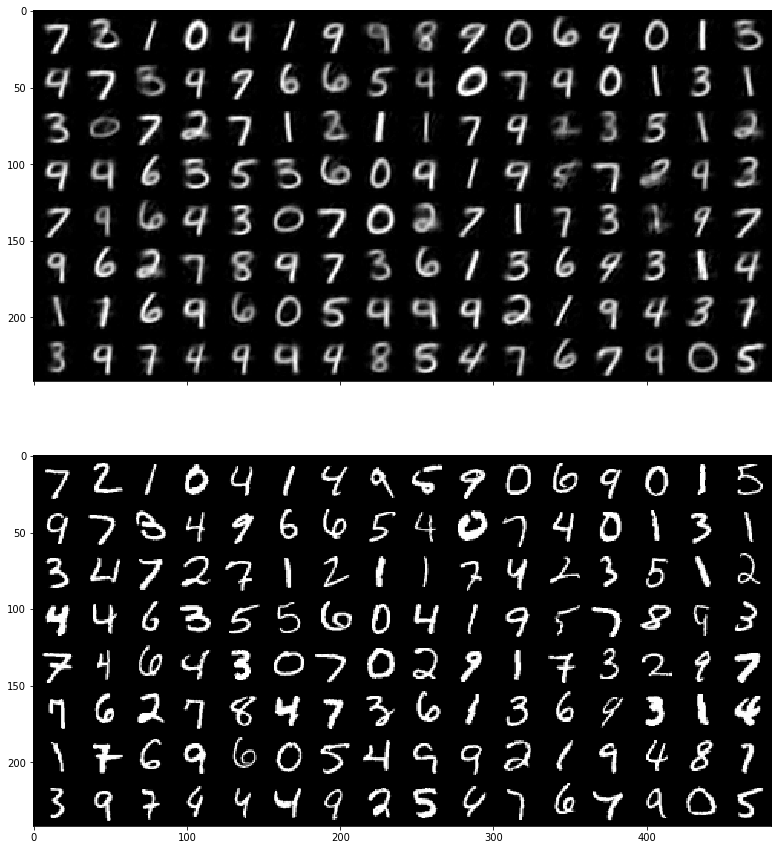

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 15))

ax1.imshow(make_grid(out.float(), nrow=16).numpy().transpose(1, 2, 0))
ax2.imshow(make_grid(x.float(), nrow=16).numpy().transpose(1, 2, 0))

In [48]:
def get_images_and_label(dataloader):
    images, labels = [], []
    for x, y in dataloader:
        images.append(x)
        labels.append(y)
    return torch.cat(images, 0), torch.cat(labels, 0)

In [49]:
images, labels = get_images_and_label(dl_valid)
images.shape, labels.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [50]:
met = model(images.to(device), False)
met.shape

torch.Size([10000, 3])

In [51]:
train_writer.add_embedding(met, labels, images, 0, 'mnist')